<a href="https://colab.research.google.com/github/boymaoyyyy/-Final-Exam-Case-Study-/blob/main/CSelectives_1_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Oxford-IIIT Pet dataset loaded!
Train samples: 3680 Val samples: 3669


Epoch 1/5:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 1 Avg Loss: 0.3923


Epoch 2/5:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 2 Avg Loss: 0.2796


Epoch 3/5:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 3 Avg Loss: 0.2209


Epoch 4/5:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 4 Avg Loss: 0.1957


Epoch 5/5:   0%|          | 0/460 [00:00<?, ?it/s]

Epoch 5 Avg Loss: 0.1598


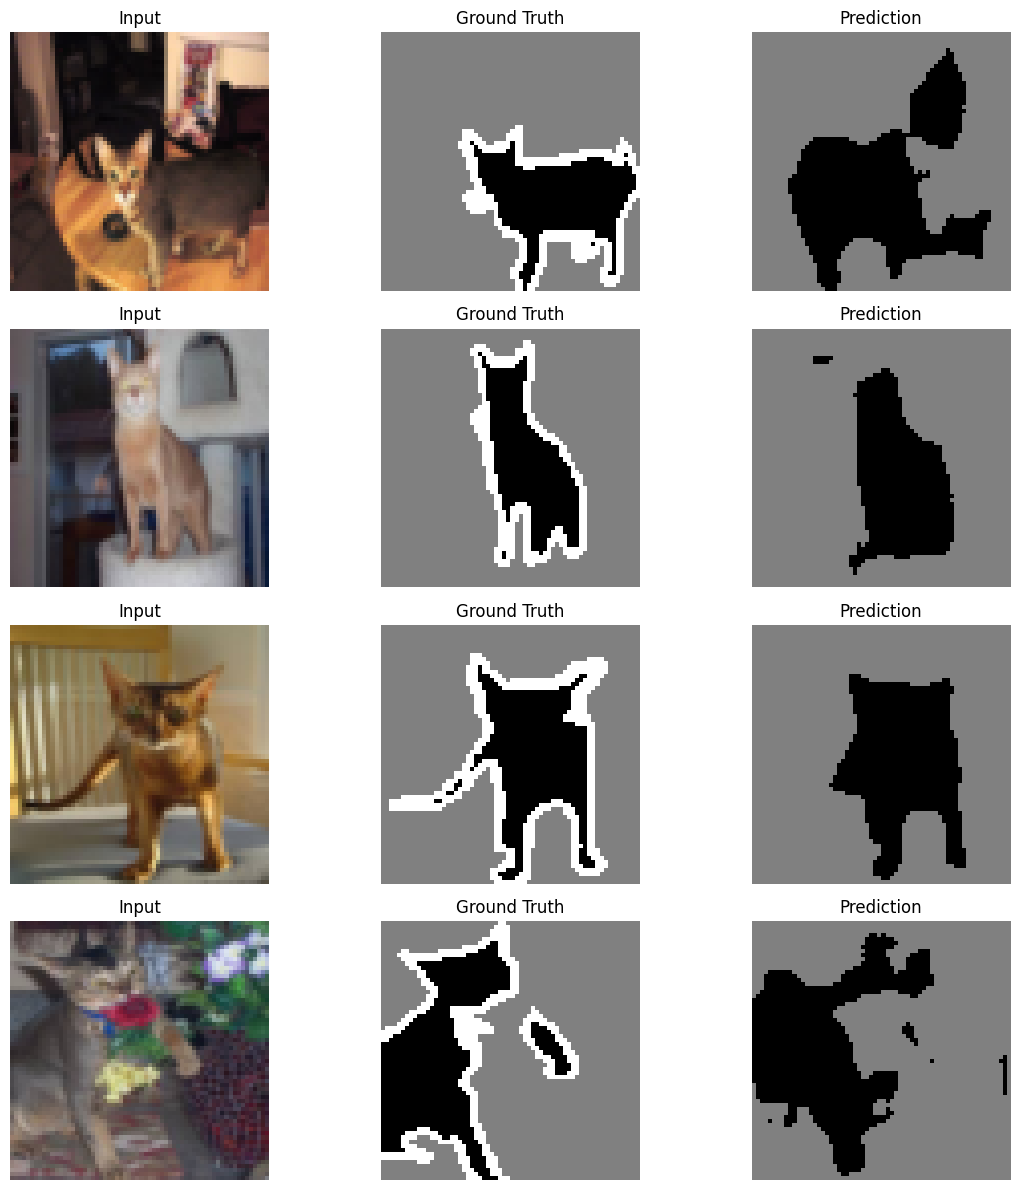

In [1]:
# =============================================================
# Oxford-IIIT Pet + Attention U-Net (Fast Demo – Fixed & Safe)
# =============================================================

# 1. Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2. Dataset Loading (with correct label remapping)
# -----------------------------
transform_img = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Oxford-IIIT Pet segmentation masks: 1=FG, 2=BG, 3=boundary
# We map: 1→0 (FG), 2→1 (BG), 3→2 (ignore)
transform_mask = transforms.Compose([
    transforms.Resize((64, 64), interpolation=InterpolationMode.NEAREST),
    transforms.PILToTensor(),
    lambda x: (x.squeeze(0) - 1).long()  # Remap 1,2,3 → 0,1,2
])

train_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=transform_img,
    target_transform=transform_mask
)

val_dataset = datasets.OxfordIIITPet(
    root="./data",
    split="test",
    target_types="segmentation",
    download=True,
    transform=transform_img,
    target_transform=transform_mask
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Oxford-IIIT Pet dataset loaded!")
print("Train samples:", len(train_dataset), "Val samples:", len(val_dataset))

# -----------------------------
# 3. Attention U-Net (3 output classes)
# -----------------------------
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, 1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, 1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.Conv2d(F_int, 1, 1), nn.BatchNorm2d(1), nn.Sigmoid())
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class UNetAttention(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.encoder1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.decoder3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.decoder2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.encoder1(x)
        e2 = self.encoder2(self.pool1(e1))
        e3 = self.encoder3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))

        d3 = self.up3(b)
        e3_att = self.att3(d3, e3)
        d3 = self.decoder3(torch.cat([d3, e3_att], dim=1))

        d2 = self.up2(d3)
        e2_att = self.att2(d2, e2)
        d2 = self.decoder2(torch.cat([d2, e2_att], dim=1))

        d1 = self.up1(d2)
        e1_att = self.att1(d1, e1)
        d1 = self.decoder1(torch.cat([d1, e1_att], dim=1))

        return self.final(d1)

# -----------------------------
# 4. Model, Loss, Optimizer
# -----------------------------
model = UNetAttention(in_channels=3, out_channels=3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=2)  # ignore boundary class
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

# -----------------------------
# 5. Training Loop (5 epochs – fast but effective)
# -----------------------------
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs = imgs.to(device)
        masks = masks.to(device)

        # Optional safety check (comment out after verification)
        # assert masks.min() >= 0 and masks.max() <= 2, f"Invalid mask: {masks.min()}, {masks.max()}"

        optimizer.zero_grad()
        outputs = model(imgs)  # [B, 3, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    print(f"Epoch {epoch+1} Avg Loss: {total_loss/len(train_loader):.4f}")

# -----------------------------
# 6. Visualize Predictions
# -----------------------------
model.eval()
imgs, masks = next(iter(val_loader))
imgs = imgs.to(device)
with torch.no_grad():
    outputs = model(imgs)
    preds = outputs.argmax(dim=1).cpu()  # [B, H, W]

batch_size = imgs.shape[0]
plt.figure(figsize=(12, 3 * batch_size))
for i in range(batch_size):
    # Input
    plt.subplot(batch_size, 3, i*3+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu())
    plt.title("Input")
    plt.axis('off')

    # Ground truth (0=FG, 1=BG, 2=ignored)
    plt.subplot(batch_size, 3, i*3+2)
    plt.imshow(masks[i].cpu(), vmin=0, vmax=2, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Prediction
    plt.subplot(batch_size, 3, i*3+3)
    plt.imshow(preds[i], vmin=0, vmax=2, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
plt.tight_layout()
plt.show()